#Decision tree

##Install pyspark

In [ ]:
%pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import packages

In [ ]:
import pyspark
from pyspark.sql import SparkSession

#from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, when, isnull

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix


Create spark session

In [ ]:
spark = SparkSession.builder.appName('MlLib - Decision Tree').getOrCreate()

##Download dan upload dataset

Dokumentasi dataset dapat dilihat [di sini](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

Deskripsi kolom adalah sebagai berikut:

Variabel input :
1. age (numeric)
2. job : type of job (categorical: `'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown'`)
3. marital : marital status (categorical: `'divorced','married','single','unknown'`; note: `'divorced'` means divorced or widowed)
4. education (categorical: `'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown'`)
5. default: has credit in default? (categorical: `'no','yes','unknown'`)
6. housing: has housing loan? (categorical: `'no','yes','unknown'`)
7. loan: has personal loan? (categorical: `'no','yes','unknown'`)
8. contact: contact communication type (categorical: `'cellular','telephone'`)
9. month: last contact month of year (categorical: `'jan', 'feb', 'mar', ..., 'nov', 'dec'`)
10. day_of_week: last contact day of the week (categorical: `'mon','tue','wed','thu','fri'`)
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: `'failure','nonexistent','success'`)

Target :
21. deposit. has the client subscribed a term deposit? (binary: 'yes','no')

In [ ]:
!wget https://raw.githubusercontent.com/urfie/DataAnalytics/main/bank.csv

--2023-06-22 18:15:46--  https://raw.githubusercontent.com/urfie/DataAnalytics/main/bank.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 292303 (285K) [text/plain]
Saving to: ‘bank.csv.2’

bank.csv.2          100%[===================>] 285.45K  --.-KB/s    in 0.02s   

2023-06-22 18:15:46 (11.7 MB/s) - ‘bank.csv.2’ saved [292303/292303]



In [ ]:
df = spark.read.csv(path='bank.csv',
                    sep=',',
                    header = True,
                    inferSchema = True)

In [ ]:
df.show(5)

+----+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+-------+
| _c0|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+----+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+-------+
|8422| 31|     admin.| single|secondary|     no|    554|    yes|  no|cellular|  5|  feb|      94|       1|   -1|       0| unknown|     no|
|9226| 43|blue-collar|married|secondary|     no|    514|    yes| yes|cellular| 20|  apr|      34|       2|   -1|       0| unknown|     no|
|8162| 26|blue-collar| single|secondary|     no|    277|     no|  no| unknown| 14|  may|     514|       2|   -1|       0| unknown|     no|
|4337| 39|   services| single|secondary|     no|     91|     no|  no|cellular|  3|  sep|     213|       1|  185|       1| success|    yes|
|2438| 40| management|marri

##Explore dataset

Jumlah record

In [ ]:
df.count()

3349

Tampilkan skema dan contoh records

In [ ]:
df.printSchema()
df.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+----+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+-------+
| _c0|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+----+---+-----------+-

Rangkuman statistik

In [ ]:
df.describe().show()

+-------+-----------------+------------------+-------+--------+---------+-------+-----------------+-------+----+--------+-----------------+-----+-----------------+------------------+------------------+------------------+--------+-------+
|summary|              _c0|               age|    job| marital|education|default|          balance|housing|loan| contact|              day|month|         duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+-----------------+------------------+-------+--------+---------+-------+-----------------+-------+----+--------+-----------------+-----+-----------------+------------------+------------------+------------------+--------+-------+
|  count|             3349|              3349|   3349|    3349|     3349|   3349|             3349|   3349|3349|    3349|             3349| 3349|             3349|              3349|              3349|              3349|    3349|   3349|
|   mean|5528.981785607644|41.531501940877874|  

##Clean Dataset

Cek null value

In [ ]:
for i in df.columns:
  print(i,' \t:',df.where(col(i).isNull()).count(), 'records')

_c0  	: 0 records
age  	: 0 records
job  	: 0 records
marital  	: 0 records
education  	: 0 records
default  	: 0 records
balance  	: 0 records
housing  	: 0 records
loan  	: 0 records
contact  	: 0 records
day  	: 0 records
month  	: 0 records
duration  	: 0 records
campaign  	: 0 records
pdays  	: 0 records
previous  	: 0 records
poutcome  	: 0 records
deposit  	: 0 records


##Transform dataset

###Transform label

Kita akan menambahkan label berdasarkan kolom `deposit`, yaitu 1 jika `deposit` = `Yes` dan 0 jika `No`.

In [ ]:
df = df.withColumn('label', when(col('deposit')=="no", 0).otherwise(1))
df.show(5)

+----+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+-------+-----+
| _c0|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|label|
+----+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+-------+-----+
|8422| 31|     admin.| single|secondary|     no|    554|    yes|  no|cellular|  5|  feb|      94|       1|   -1|       0| unknown|     no|    0|
|9226| 43|blue-collar|married|secondary|     no|    514|    yes| yes|cellular| 20|  apr|      34|       2|   -1|       0| unknown|     no|    0|
|8162| 26|blue-collar| single|secondary|     no|    277|     no|  no| unknown| 14|  may|     514|       2|   -1|       0| unknown|     no|    0|
|4337| 39|   services| single|secondary|     no|     91|     no|  no|cellular|  3|  sep|     213|       1|  185|       1| success|

###Encode features

MLlib model membutuhkan input bertipe numerik, sehingga variabel kategorik harus di-encoding/ditransformasi menjadi variabel numerik sebelum digunakan untuk training maupun testing. Proses ini disebut juga dengan *encoding*.

Metode yang banyak dilakukan adalah *dummy encoding*, yaitu mentransformasi variabel kategorik berkardinal N menjadi binary string berukuran N-1.

In [ ]:
inputColNames =  ['job','marital','education','default','housing','loan']
continuousColNames = ['age','balance','campaign','pdays','duration']
labelCol = 'label'

Untuk melakukan proses tersebut, kita buat pipeline encoding yang terdiri dari : `StringIndexer` --> `OneHotEncoder` --> `VectorAssembler`

Hasil dari proses encoding ini adalah pasangan feature-label, di mana kolom feature berupa sparse vector, yaitu vector yang mayoritas nilainya 0.

In [ ]:
indexers = []
for column in inputColNames:
  indexers.append(StringIndexer(inputCol=column,
                                outputCol="{0}_indexed".format(column)))

In [ ]:
encoders = []
for indexer in indexers:
  encoders.append(OneHotEncoder(inputCol=indexer.getOutputCol(),
                                outputCol="{0}_encoded".format(indexer.getOutputCol())))

In [ ]:
inputColumns = []
for encoder in encoders:
  inputColumns.append(encoder.getOutputCol())

assembler = VectorAssembler(inputCols=inputColumns + continuousColNames,
                           outputCol="features")


Rangkai komponen di atas ke dalam sebuah pipeline

In [ ]:
pipeline = Pipeline(stages=indexers + encoders + [assembler])

Fit pipeline dan transform data

In [ ]:
data_encoder=pipeline.fit(df) #fit pipeline
data = data_encoder.transform(df) #transform data
transformed = data.select('features','label') #select kolom yang akan digunakan

Tampilkan hasilnya

In [ ]:
data.show(5,False)
transformed.show(5, False)

+----+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+-------+-----+-----------+---------------+-----------------+---------------+---------------+------------+-------------------+-----------------------+-------------------------+-----------------------+-----------------------+--------------------+------------------------------------------------------------------------------------------+
|_c0 |age|job        |marital|education|default|balance|housing|loan|contact |day|month|duration|campaign|pdays|previous|poutcome|deposit|label|job_indexed|marital_indexed|education_indexed|default_indexed|housing_indexed|loan_indexed|job_indexed_encoded|marital_indexed_encoded|education_indexed_encoded|default_indexed_encoded|housing_indexed_encoded|loan_indexed_encoded|features                                                                                  |
+----+---+-----------+-------+---------+-------+-------+-------+----

####Penjelasan step by step

In [ ]:
data['loan', 'loan_indexed', 'loan_indexed_encoded',
     'education', 'education_indexed', 'education_indexed_encoded'].show(5, False)

+----+------------+--------------------+---------+-----------------+-------------------------+
|loan|loan_indexed|loan_indexed_encoded|education|education_indexed|education_indexed_encoded|
+----+------------+--------------------+---------+-----------------+-------------------------+
|no  |0.0         |(1,[0],[1.0])       |secondary|0.0              |(3,[0],[1.0])            |
|yes |1.0         |(1,[],[])           |secondary|0.0              |(3,[0],[1.0])            |
|no  |0.0         |(1,[0],[1.0])       |secondary|0.0              |(3,[0],[1.0])            |
|no  |0.0         |(1,[0],[1.0])       |secondary|0.0              |(3,[0],[1.0])            |
|no  |0.0         |(1,[0],[1.0])       |tertiary |1.0              |(3,[1],[1.0])            |
+----+------------+--------------------+---------+-----------------+-------------------------+
only showing top 5 rows



1. `StringIndexer` mengubah variabel kategorik menjadi indeks berupa integer 0 sampai N-1. Kolom `gender_indexed` nilainya menjadi 0 dan 1. Sedangkan kolom `dept_indexed` 0 sampai 5.

2. `OneHotEncoder` mentransformasi indeks di atas menjadi binary vector `00000` sampai `10000`. Karena vector yang dihasilkan nilainya hampir semuanya 0, maka MLlib merepresentasikannya sebagai sparse vector. Sparse vector di MLlib disimpan dengan format `(ukuran_vektor_sebenarnya, indeks_nonzero, nilai_nonzero)`


In [ ]:
data[['education_indexed_encoded']].distinct().show()

+-------------------------+
|education_indexed_encoded|
+-------------------------+
|            (3,[2],[1.0])|
|            (3,[1],[1.0])|
|            (3,[0],[1.0])|
|                (3,[],[])|
+-------------------------+




Misalnya untuk kolom `education_indexed_encoded`
- `(3,[2],[1.0])` berarti vektor ukuran 3 dengan kolom ke 2 bernilai 1.0, dan selebihnya 0 --> `[0, 0, 1.0]`
- `(3,[],[])` berarti vektor ukuran 3 tanpa nonzero kolom alias semuanya 0 --> `[0, 0, 0]`
- `(3,[1],[1.0])` berarti vektor ukuran 3 dengan kolom ke 1 bernilai 1.0, dan selebihnya 0 --> `[0, 1.0, 0]`

dst.


Selanjutnya `VectorAssembler` menggabungkan seluruh variabel hasil encoding dan variabel numerik yang akan digunakan untuk training, ke dalam sebuah sparse vector dalam kolom `features`.

In [ ]:
data[['features']].show(5, False)

+------------------------------------------------------------------------------------------+
|features                                                                                  |
+------------------------------------------------------------------------------------------+
|(24,[3,12,13,16,18,19,20,21,22,23],[1.0,1.0,1.0,1.0,1.0,31.0,554.0,1.0,-1.0,94.0])        |
|(24,[1,11,13,16,19,20,21,22,23],[1.0,1.0,1.0,1.0,43.0,514.0,2.0,-1.0,34.0])               |
|(24,[1,12,13,16,17,18,19,20,21,22,23],[1.0,1.0,1.0,1.0,1.0,1.0,26.0,277.0,2.0,-1.0,514.0])|
|(24,[4,12,13,16,17,18,19,20,21,22,23],[1.0,1.0,1.0,1.0,1.0,1.0,39.0,91.0,1.0,185.0,213.0])|
|(24,[0,11,14,16,17,18,19,21,22,23],[1.0,1.0,1.0,1.0,1.0,1.0,40.0,2.0,98.0,131.0])         |
+------------------------------------------------------------------------------------------+
only showing top 5 rows



Total ukuran vektor `features` adalah **11 + 2 + 3 + 1 + 1 + 1 + 5 = 24**, yaitu :
- 11 kolom untuk `job`
- 2 kolom untuk `marital`
- 3 kolom utuk `education`
- masing-masing 1 kolom untuk `default,housing`, dan `loan`
- serta 5 untuk kolom numerik lainnya (`'age','balance','campaign','pdays','duration'`)

Misalnya untuk record pertama,

 `(24,[3,12,13,16,18,19,20,21,22,23],[1.0,1.0,1.0,1.0,1.0,31.0,554.0,1.0,-1.0,94.0]) ` berarti vektor `[0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,1.0,0,0,1.0,0,1.0,31.0,554.0,1.0,-1.0,94.0]`,

yaitu vektor berukuran 24, dengan nilai nonzero di indeks ke `3,12,13,16,18,19,20,21,22, dan 23`.

###Split the data to training and test data sets

In [ ]:
(trainingData, testData) = transformed.randomSplit([0.7, 0.3])

trainingData.show(5, False)
testData.show(5, False)

+-------------------------------------------------------------------------------------------+-----+
|features                                                                                   |label|
+-------------------------------------------------------------------------------------------+-----+
|(24,[0,11,13,16,17,18,19,20,21,22,23],[1.0,1.0,1.0,1.0,1.0,1.0,29.0,231.0,1.0,14.0,1075.0])|1    |
|(24,[0,11,13,16,17,18,19,20,21,22,23],[1.0,1.0,1.0,1.0,1.0,1.0,33.0,369.0,1.0,-1.0,446.0]) |1    |
|(24,[0,11,13,16,17,18,19,20,21,22,23],[1.0,1.0,1.0,1.0,1.0,1.0,34.0,369.0,3.0,342.0,868.0])|1    |
|(24,[0,11,13,16,17,18,19,20,21,22,23],[1.0,1.0,1.0,1.0,1.0,1.0,40.0,4396.0,3.0,-1.0,432.0])|1    |
|(24,[0,11,13,16,17,18,19,20,21,22,23],[1.0,1.0,1.0,1.0,1.0,1.0,40.0,8486.0,3.0,-1.0,260.0])|0    |
+-------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+--------------------------------------------------------------------------

###Fit Decision Tree Classification Model

In [ ]:
dTree = DecisionTreeClassifier(labelCol='label',
                               featuresCol='features')

Model training

In [ ]:
model = dTree.fit(trainingData)

Tampilkan deskripsi model

In [ ]:
print(model)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b86eed2f3acf, depth=5, numNodes=47, numClasses=2, numFeatures=24


Lakukan Prediksi terhadap data test

In [ ]:
predictions = model.transform(testData)

Tampilkan hasil prediksi

In [ ]:
predictions.show(5)

+--------------------+-----+-------------+--------------------+----------+
|            features|label|rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+----------+
|(24,[0,11,13,16,1...|    1| [37.0,159.0]|[0.18877551020408...|       1.0|
|(24,[0,11,13,16,1...|    0| [200.0,29.0]|[0.87336244541484...|       0.0|
|(24,[0,11,13,16,1...|    0|  [75.0,84.0]|[0.47169811320754...|       1.0|
|(24,[0,11,13,16,1...|    1|  [12.0,96.0]|[0.11111111111111...|       1.0|
|(24,[0,11,13,16,1...|    1| [47.0,319.0]|[0.12841530054644...|       1.0|
+--------------------+-----+-------------+--------------------+----------+
only showing top 5 rows



###Evaluation

Hitung dan tampilkan evaluasi hasil prediksi model terhadap data test

In [ ]:
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="accuracy")
evaluator_pr = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="precisionByLabel")
evaluator_rc = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="recallByLabel")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="f1")

In [ ]:
accuracy = evaluator_acc.evaluate(predictions)
precision = evaluator_pr.evaluate(predictions)
recall = evaluator_rc.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

In [ ]:
print ("Accuracy = %s" % accuracy)
print ("Precision = %s" % precision)
print ("Recall = %s" % recall)
print ("F1 metric = %s" % f1)
print ("Prediction Error = %s" % (1-accuracy))

Accuracy = 0.7690782953419227
Precision = 0.8218884120171673
Recall = 0.7185741088180112
F1 metric = 0.7689263106367848
Prediction Error = 0.23092170465807726


####Visualisasi Confusion Matrix

Kita bisa menampilkan summary kinerja model menggunakan confusion matrix, yaitu matriks yang menampilkan perbandingan label sebenarnya dengan label hasil prediksi.

Kita gunakan fungsi `confusion_matrix` dari package `sklearn.metrics`

In [ ]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[383, 150],
       [ 83, 393]])

Kita bisa visualisasikan confusion matrix menggunakan `heatmap plot` dari `Seaborn`.

Keterangan confusion matrix :
- Sumbu Y mewakili nilai sebenarnya, yaitu Negative jika tidak melakukan deposit (target label = 0), dan Positive jika melakukan deposit (target label = 1).
- Sumbu X mewakili nilai hasil prediksi.





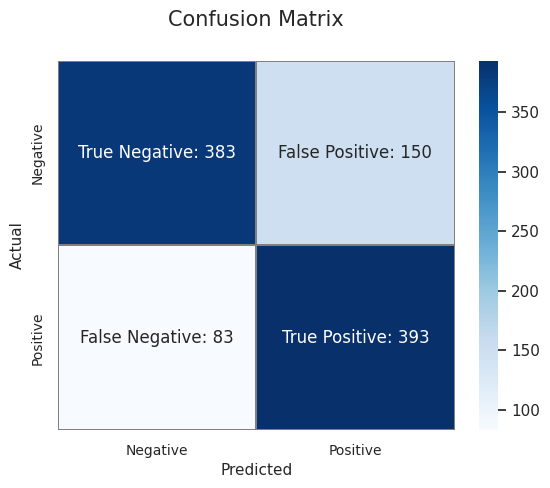

In [ ]:
sns.set_theme()

annot_label = np.array([["True Negative: %d" % (cnf_matrix[0][0]),
           "False Positive: %d" % (cnf_matrix[0][1])],
          ["False Negative: %d" % (cnf_matrix[1][0]),
           "True Positive: %d" % (cnf_matrix[1][1])]])

ax = sns.heatmap(cnf_matrix,
                 annot=annot_label,
                 fmt="",
                 cmap=plt.cm.Blues,
                 linewidths=.1,
                 linecolor="grey")

# set x-axis label and ticks.
ax.set_xlabel("Predicted", fontsize=11)
ax.xaxis.set_ticklabels(['Negative', 'Positive'], fontsize=10)

# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=11)
ax.yaxis.set_ticklabels(['Negative', 'Positive'], fontsize=10)

# set plot title
ax.set_title("Confusion Matrix", fontsize=15, pad=25)

plt.show()